In [22]:
import spacy

nlp = spacy.load("nl_core_news_lg")
from util.conferences import get_conference_data, correct_cwd, get_sentences
from util.infections import get_infection_data
import datetime as dt
from tqdm.notebook import tqdm
import matplotlib
import matplotlib.pyplot as plt

In [23]:
correct_cwd()

In [24]:
rutte_data, de_jonge_data = get_conference_data(include_journalist_questions=False)
rutte_texts = [content['text'] for content in rutte_data]
de_jonge_texts = [content['text'] for content in de_jonge_data]

In [25]:
rutte_sentences = [get_sentences(rutte_text) for rutte_text in rutte_texts]
date_strings = [content['date'] for content in rutte_data]
dates = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in date_strings]
de_jonge_sentences = [get_sentences(de_jonge_text) for de_jonge_text in de_jonge_texts]

In [26]:
def stam_ww(token_tags):
    required_tags = ['WW', 'ev', 'tgw']
    return all([required_position in token_tags for required_position in required_tags])

In [27]:
def has_imperative_form(sentence: str):
    doc = nlp(sentence)
    subjects = [tok.dep_ for tok in doc if (tok.dep_ == 'nsubj')]
    verbs = [tok for tok in doc if stam_ww(tok.tag_)]
    forbidden_verbs = ['kijk', 'is', 'staat']
    imperative_verb = doc[0] in verbs and not (str(doc[0]).lower() in forbidden_verbs)
    if not subjects and imperative_verb and not '?' in sentence:
        return sentence
    return False

In [28]:
relative_proportions = []

for rut_doc, de_jonge_doc in tqdm(list(zip(rutte_sentences, de_jonge_sentences))):
    doc = rut_doc + de_jonge_doc
    count = 0
    for sentence in doc:
        if has_imperative_form(sentence):
            count += 1
            print(sentence)
    relative_proportions.append(count / len(doc))

  0%|          | 0/60 [00:00<?, ?it/s]

Doe dit, maak hier gebruik van deze aanwijzingen: handen wassen, in je elleboog niezen en gebruik maken van papieren zakdoekjes.
Denk aan het niet kunnen bezoeken van opa of oma in het verpleeghuis op dit moment.
Wees aardig en begripvol voor elkaar.
Denk in Europa bijvoorbeeld om Oostenrijk, Italië en Spanje, maar ook landen buiten Europa zoals Iran, Zuid-Korea en China.
Ga niet met zijn allen naar de gebruikelijke hotspots toe.
Denk aan de stranden, de recreatiegebieden en dergelijke.
Doe het niet.
Blijf thuis, bleib zu Hause, rester à la maison.
Hou dus alsjeblieft vol.
Maak van die boodschappen geen uitje met kinderen en vrouw of man.
Ga niet onnodig op pad.
Denk aan de kappers, denk op termijn misschien aan de sportscholen of aan de sauna’s.
Denk bijvoorbeeld aan de horeca en de terrassen.
Houd anderhalve meter afstand.
Vermijd drukte.
Rest mij nog iedereen een goed Hemelvaartsweekend te wensen.
Neem die verantwoordelijkheid, niet alleen voor jezelf maar ook en vooral voor elkaar.

In [29]:
# from https://matplotlib.org/devdocs/gallery/subplots_axes_and_figures/two_scales.html
def two_lines(t1, data1, t2, data2):
    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('date')
    ax1.set_ylabel('imperative usage', color=color)
    ax1.plot(t1, data1, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel('new infections per day MA', color=color)  # we already handled the x-label with ax1
    ax2.plot(t2, data2, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-l
    matplotlib.rcParams['figure.dpi'] = 300
    plt.savefig('output/imperative_usage-infections.png')
    plt.show()

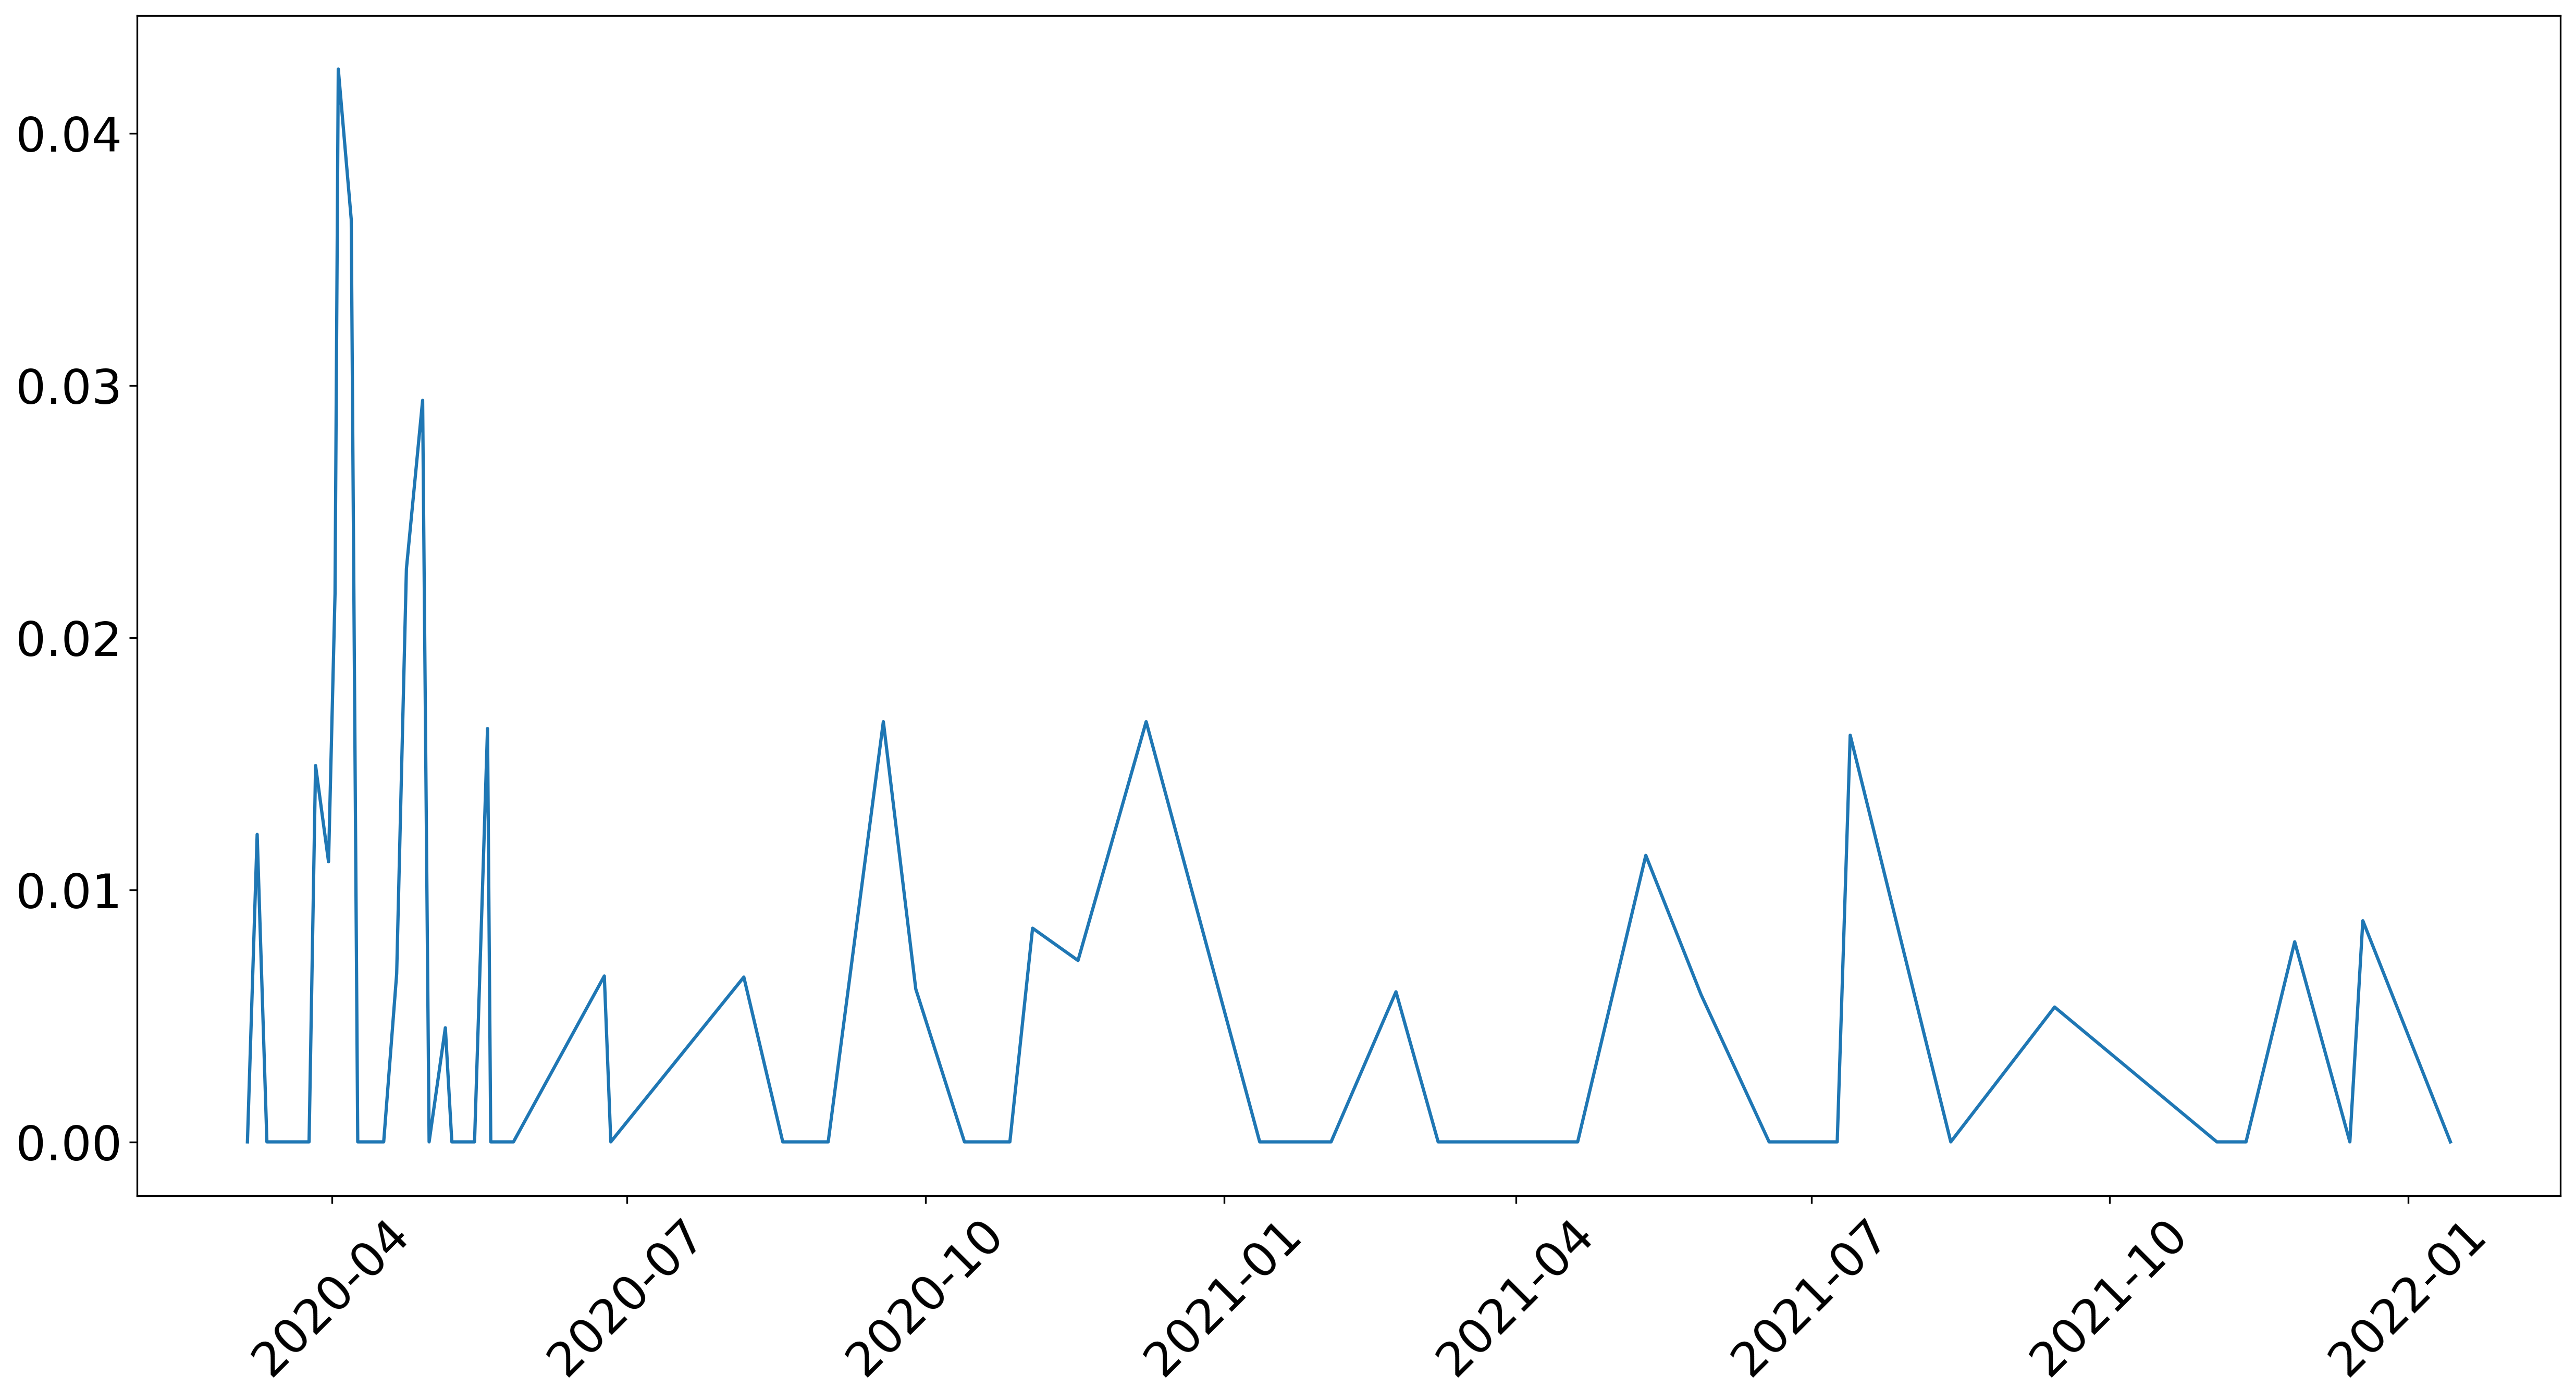

In [30]:
x = dates
y = relative_proportions
plt.plot(x, y)
plt.xticks(rotation=45)
plt.show()

In [31]:
infections = get_infection_data()
infections['new_infection_ma'] = infections['new_infections'].rolling(window=7).mean()
infections

,date,total_infections,new_infections,new_infection_ma
0,2020-03-13,804,804,NaN
1,2020-03-14,959,155,NaN
2,2020-03-15,1135,176,NaN
3,2020-03-16,1413,278,NaN
4,2020-03-17,1705,292,NaN
...,...,...,...,...
679,2022-01-21,3778287,57471,39624.571429
680,2022-01-22,3824344,46057,41653.714286
681,2022-01-23,3889669,65325,45810.000000
682,2022-01-24,3954299,64630,48992.571429


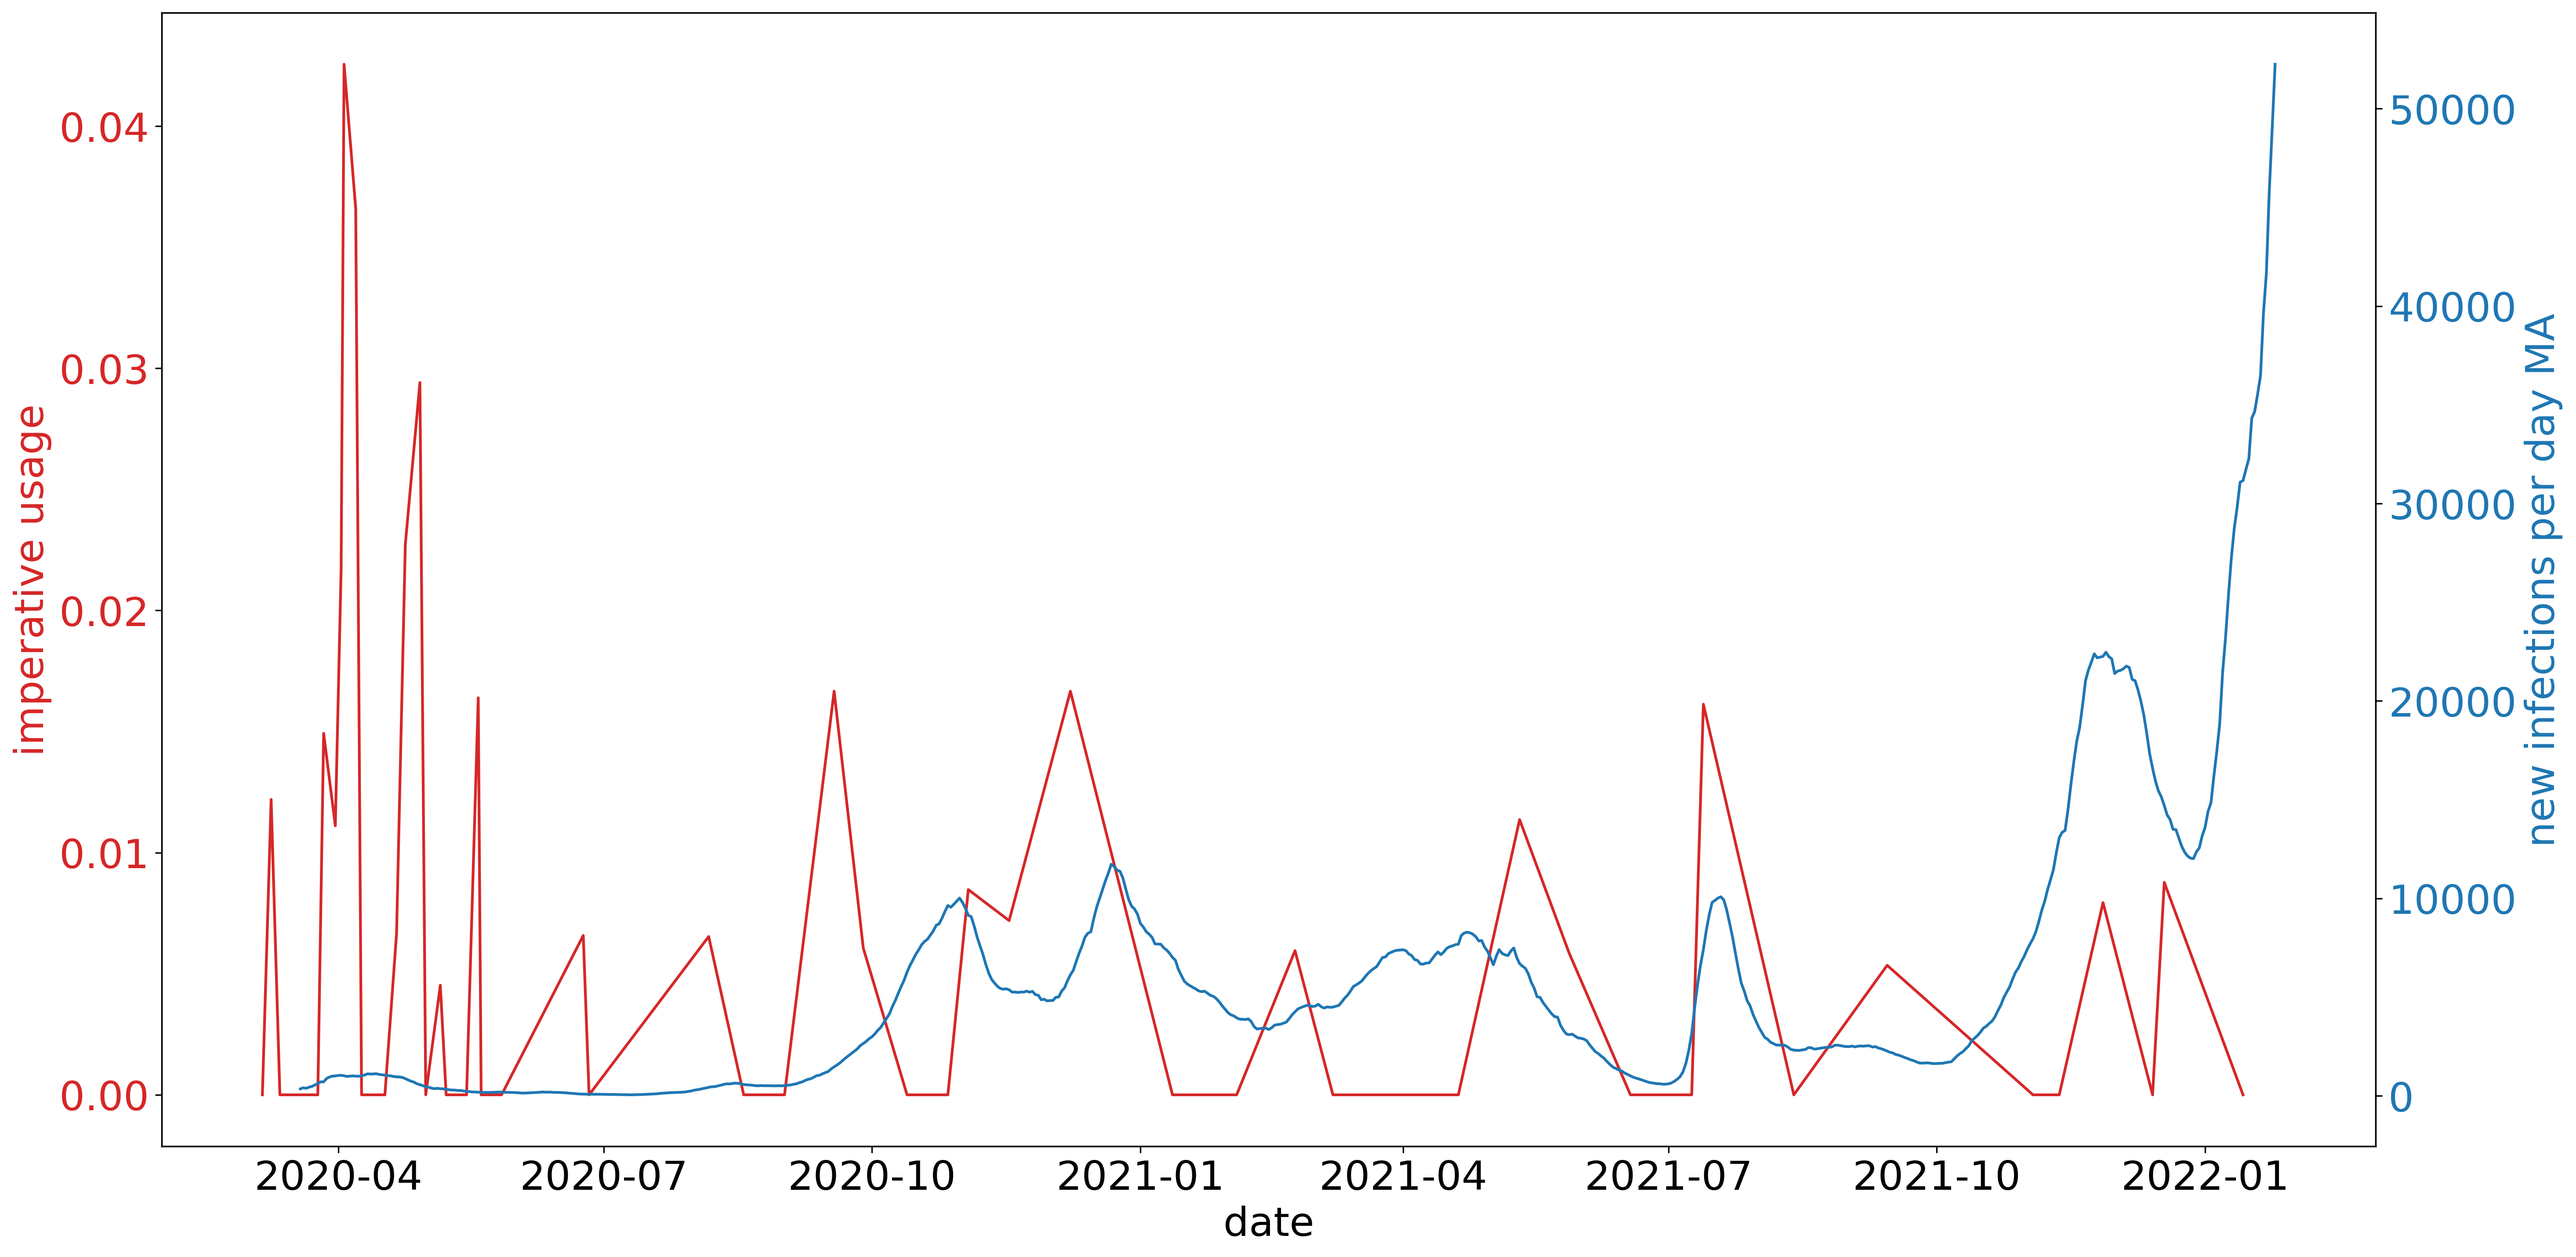

In [32]:
x2 = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in infections.date]
y2 = infections.new_infection_ma
two_lines(x, y, x2, y2)

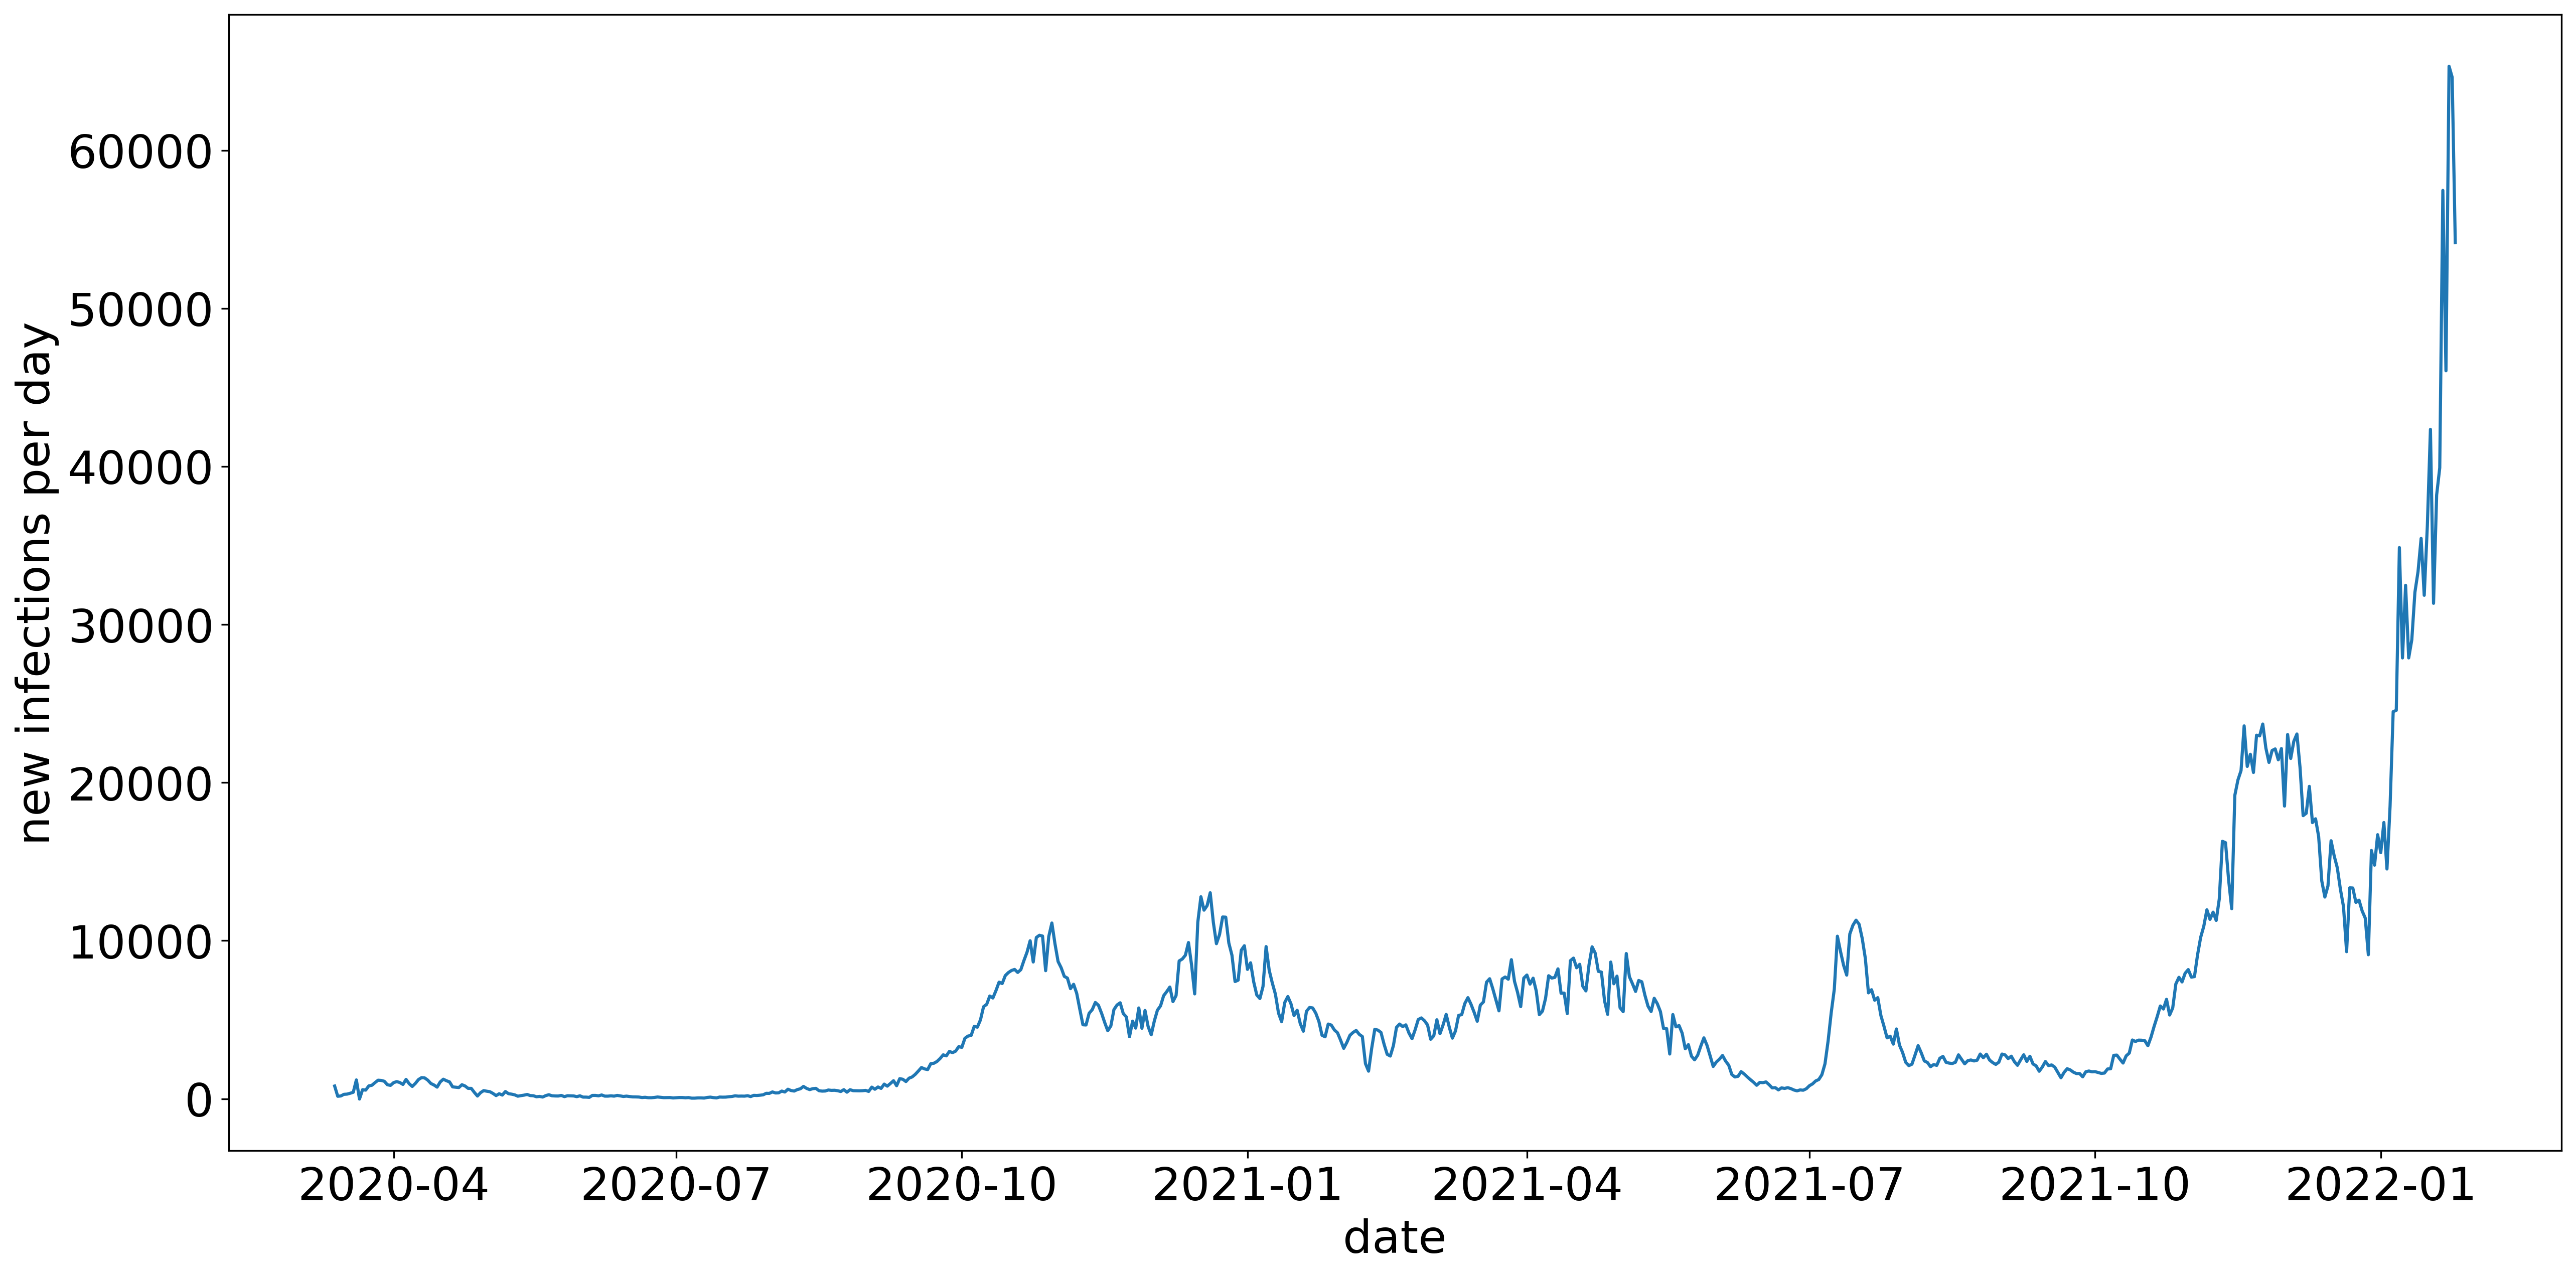

In [33]:
plt.plot(x2, infections.new_infections)
plt.xlabel('date')
matplotlib.rcParams['figure.dpi'] = 300
plt.ylabel('new infections per day')
plt.savefig('output/infections.png')
plt.show()